In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io
from skimage.exposure import rescale_intensity
from skimage.util import compare_images, img_as_uint
from datetime import datetime
import random
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

In order to extract the Hoechst channel for the registration I will load the images as numpy arrays rather than using *sitk.ReadImage()* because after spending a lot of time googling I couldn't find a way to just get one channel of an sitk image.

In [16]:
# Read images
path_folder = r"/links/groups/treutlein/DATA/imaging/PW/4i/plate14"
path_fixed_img = os.path.join(path_folder, 
                              r"cycle1/stitched/multichannel_Point0016_Point00{ii}_ChannelSD 640,SD 488.tif")
path_moving_img = os.path.join(path_folder, 
                              r"cycle2/stitched/multichannel_Point0016_Point00{ii}_ChannelSD 640,SD 488.tif")

fixed_img_all = io.imread(path_fixed_img)
moving_img_all = io.imread(path_moving_img)

In [17]:
# Extract DAPI channels for alignment
fixed_img_dapi = fixed_img_all[..., 2]
moving_img_dapi = moving_img_all[..., 2]

# Rescale intensities
min_val = 0
max_quantile = 0.9999  # a very small number of pixels is much much higher than the rest

max_val = np.quantile(fixed_img_dapi, max_quantile)
fixed_img_dapi = rescale_intensity(fixed_img_dapi, in_range=(min_val, max_val))

max_val = np.quantile(moving_img_dapi, max_quantile)
moving_img_dapi = rescale_intensity(moving_img_dapi, in_range=(min_val, max_val))

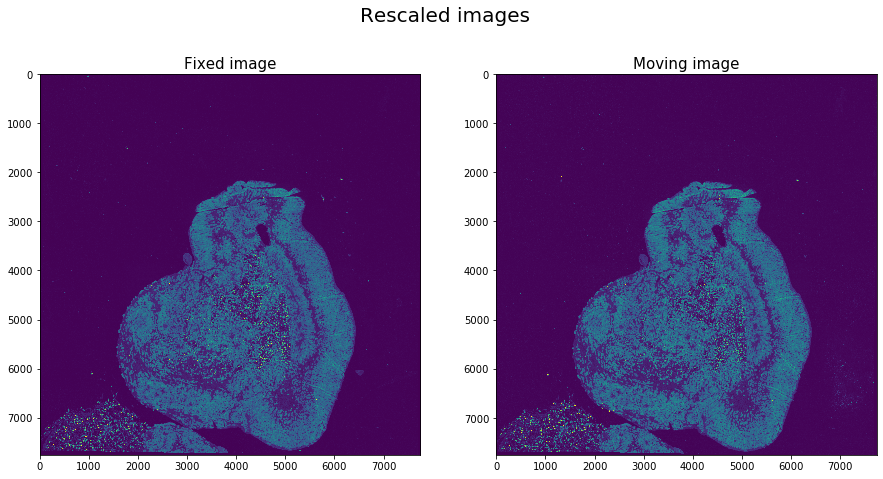

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15, 7.5))

ax[0].imshow(fixed_img_dapi)
ax[0].set_title("Fixed image", fontsize=15)
ax[1].imshow(moving_img_dapi)
ax[1].set_title("Moving image", fontsize=15)
fig.suptitle("Rescaled images", fontsize=20)
plt.show()

Comparing the images before the alignment shows that the alignment is already quite decent (i.e. in the images below we can easily tell that this is the same rough region in both images) but it's still off by quite a bit.

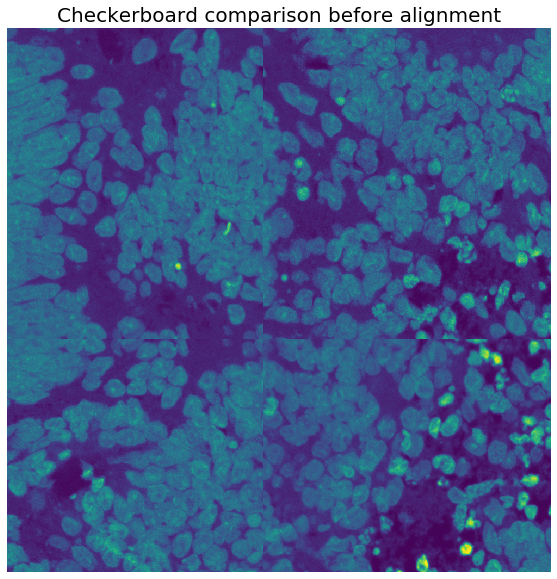

In [47]:
# Shape for both has to be the same
x_max = np.min([fixed_img_dapi.shape[0], moving_img_dapi.shape[0]])
y_max = np.min([fixed_img_dapi.shape[1], moving_img_dapi.shape[1]])

plt.imshow(compare_images(fixed_img_dapi[0:x_max, 0:y_max], 
                          moving_img_dapi[0:x_max, 0:y_max], method="checkerboard"))
plt.xlim(3400, 4400)
plt.ylim(4300, 3300)
plt.axis("off")
plt.title("Checkerboard comparison before alignment", fontsize=20)
plt.show()

Since with the previous data set there were issues with the translation step, i.e. it simply didn't work, we'll try to align the two images by doing only the translation. Since the alignment is much better to begin with this might actually work because I think the problem last time was that the organoid was so far away in the moving image that it didn't work.

In [49]:
start = datetime.now()

elstx_aligned_transl = sitk.ElastixImageFilter()
elstx_aligned_transl.SetFixedImage(sitk.GetImageFromArray(fixed_img_dapi))
elstx_aligned_transl.SetMovingImage(sitk.GetImageFromArray(moving_img_dapi))
elstx_aligned_transl.SetParameterMap(sitk.ReadParameterFile('Elastix/param_maps/translation.txt'))
#elstx_aligned_transl.SetOutputDirectory()
img_aligned_transl = elstx_aligned_transl.Execute()

print(datetime.now()-start)

0:02:22.616069


Turning the resulting aligned image back into a numpy array to check if alignment worked. Elastix prefers to work with float32 data types so it also returns the aligned image as such. In order to be able to properly compare it to our original images it seems reasonable to turn it back into a uint16 image first.  
The alignment in this zoomed in region is actually so good, that it's virtually impossible to tell which parts of the image are from the fixed image and which parts of the aligned image, which is why I **artificially increased the intensity of the aligned image in the figure below**.

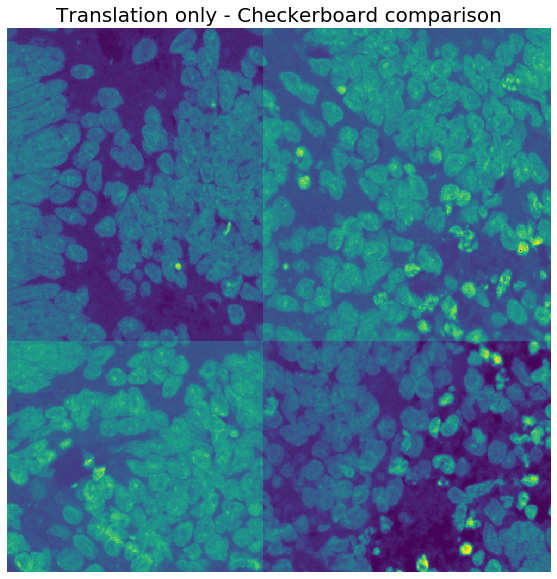

In [55]:
img_aligned_transl = sitk.Cast(img_aligned_transl, 
                               sitk.sitkUInt16)  # convert from float to uint16 (initial image is uint16)

aligned_array_transl = sitk.GetArrayFromImage(img_aligned_transl)  # convert image to numpy array

plt.imshow(compare_images(fixed_img_dapi, aligned_array_transl+10000, method="checkerboard"))
plt.xlim(3400, 4400)
plt.ylim(4300, 3300)
plt.title("Translation only - Checkerboard comparison", fontsize=20)
plt.axis("off")
plt.show()

Zooming into another region, however, shows that there is some issue with this. My guess is that either when casting to uint16 or converting to a numpy array some pixel values were messed with. 

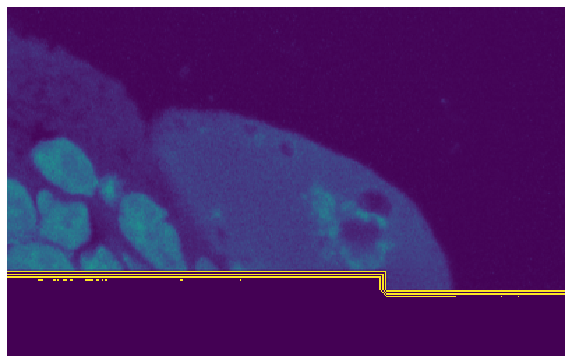

In [7]:
plt.imshow(aligned_array_transl[7500:7750, 3500:3900])
plt.axis("off")
plt.show()

We'll try to tackle that problem later on. First, let's see what the image looks like if we use a full registration (translation -> affine -> bspline). This will take much longer but should give even better results.

In [219]:
start=datetime.now()

elstx_aligned = sitk.ElastixImageFilter()
elstx_aligned.SetFixedImage(sitk.GetImageFromArray(fixed_img_dapi))
elstx_aligned.SetMovingImage(sitk.GetImageFromArray(moving_img_dapi))
elstx_aligned.SetParameterMap(sitk.ReadParameterFile('Elastix/param_maps/translation.txt'))
elstx_aligned.AddParameterMap(sitk.ReadParameterFile('Elastix/param_maps/affine.txt'))
elstx_aligned.AddParameterMap(sitk.ReadParameterFile('Elastix/param_maps/bspline_32grid.txt'))
#elstx_aligned.SetOutputDirectory()
img_aligned = elstx_aligned.Execute()

print(datetime.now()-start)

0:17:48.997148


The image below looks basically identical, but to be fair a better alignment than the one we got from the translation step was barely possible in this region.

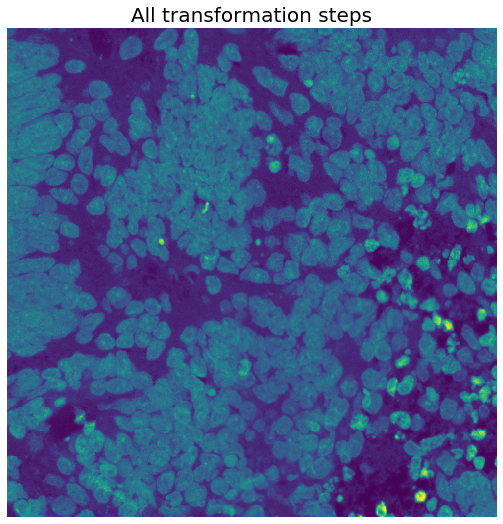

In [227]:
img_aligned = sitk.Cast(img_aligned, sitk.sitkUInt16)  # convert from float to uint16

aligned_array = sitk.GetArrayFromImage(img_aligned)  # convert image to numpy array

plt.imshow(compare_images(fixed_img_dapi, aligned_array, method="checkerboard"))
plt.xlim(3400, 4400)
plt.ylim(4300, 3300)
plt.title("All transformation steps", fontsize=20)
plt.axis("off")
plt.show()

The issue with the strange lines close to the border is still present, though. The image below also shows that adding the affine and bspline transformation did indeed make a difference in certain regions.

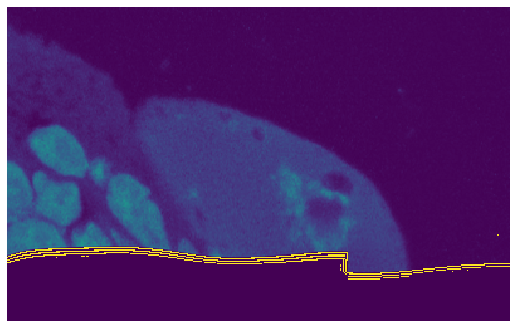

In [223]:
plt.imshow(aligned_array[7500:7750, 3500:3900])
plt.axis("off")
plt.show()

Zooming into another region reveals a further issue. While in the image above some pixels that are probably supposed to be very dark have in fact a high intensity, the image below shows the opposite, i.e. an area expected to be very bright is actually very dark.

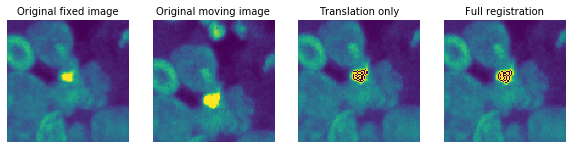

In [263]:
fig, ax = plt.subplots(1,4)

ax[0].imshow(fixed_img_dapi[5000:5100, 4175:4275])
ax[0].axis("off")
ax[0].set_title("Original fixed image", fontsize=10)

ax[1].imshow(moving_img_dapi[5000:5100, 4175:4275])
ax[1].axis("off")
ax[1].set_title("Original moving image", fontsize=10)

ax[2].imshow(aligned_array_transl[5000:5100, 4175:4275])
ax[2].axis("off")
ax[2].set_title("Translation only", fontsize=10)

ax[3].imshow(aligned_array[5000:5100, 4175:4275])
ax[3].axis("off")
ax[3].set_title("Full registration", fontsize=10)

plt.show()

In order to test whether this mistake has to do with the conversion to a numpy array of to uint16 or if it's an issue with the registration itself we can save one of the registered images, load it back into memory and then zoom into those regions:

In [60]:
sitk.WriteImage(elstx_aligned_transl.GetResultImage(), "transl_only_float.tif")  # save tranlsated image

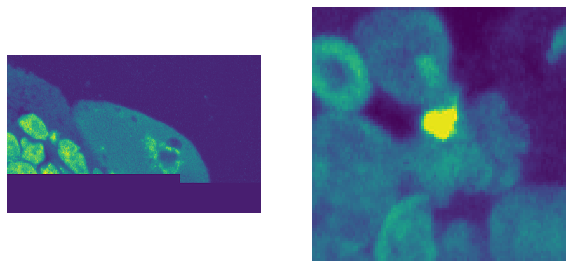

dtype: float32


In [61]:
test_img_float = io.imread("transl_only_float.tif")  # read image as numpy array

fig, ax = plt.subplots(1,2)
ax[0].imshow(test_img_float[7500:7750, 3500:3900])
ax[0].axis("off")
ax[1].imshow(test_img_float[5000:5100, 4175:4275])
ax[1].axis("off")

plt.show()

print("dtype:", test_img_float.dtype)

As we can see, the images look completely fine so it seems like the artefacts appeared during one of the conversion steps.

There is another problem though: As mentioned earlier, elastix returns the resulting image as float32 so if we save the image before casting it to uint16 it will have a different data type than our original images. The problem with this is that the intensity values are different (some are negative for example) which probably causes some issues during the pixel clustering further down the line. So we have to test if the artefacts are also not visible if we cast to uint16 and only then save the image. Since we already have a version of the image converted to this dtype using `sitk.Cast()` (see further above) we can just save that one.

In [62]:
sitk.WriteImage(img_aligned_transl, "transl_only_uint.tif")

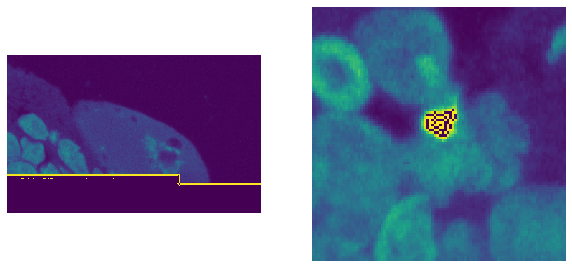

dtype: uint16


In [63]:
test_img_uint = io.imread("transl_only_uint.tif")  # read image as numpy array

fig, ax = plt.subplots(1,2)
ax[0].imshow(test_img_uint[7500:7750, 3500:3900])
ax[0].axis("off")
ax[1].imshow(test_img_uint[5000:5100, 4175:4275])
ax[1].axis("off")

plt.show()

print("dtype:", test_img_uint.dtype)

Sadly, it seems like this doesn't solve the problem but at least we now know that during the conversion from float32 to uint16 something weird is happening. The two following figures illustrate the problem: For some reason there are values above 65535 and below 0 in the float32 image and when converting this image to uint16 the values aren't just capped at 0 and 65535 but instead it seems like 65536 becomes 0, 65537 becomes 1, 65538 is suddenly 2 and so on. The same happens for values below 0 where -1 is converted to 65535, -2 to 65534 etc.

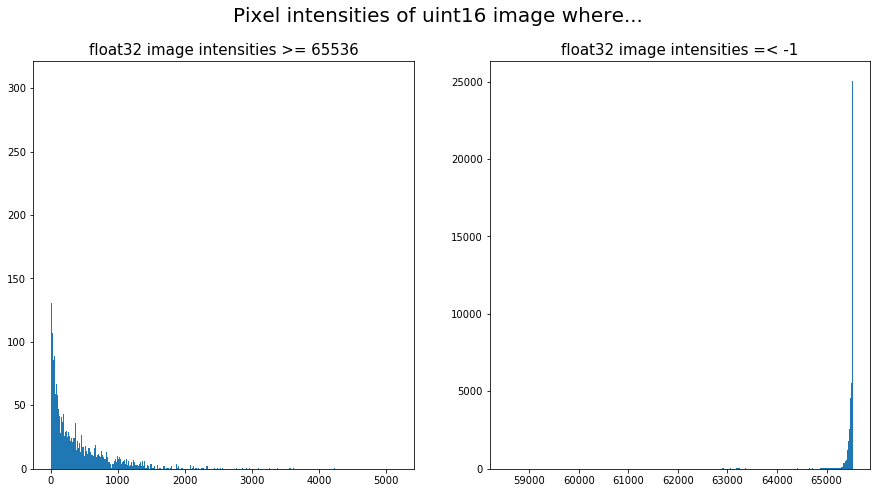

In [120]:
fig, ax = plt.subplots(1,2, figsize=(15,7.5))

fig.suptitle("Pixel intensities of uint16 image where...", fontsize=20)

ax[0].hist(test_img_uint[np.where(test_img_float >= 65536)], bins=500)
ax[0].set_title("float32 image intensities >= 65536", fontsize=15)

ax[1].hist(test_img_uint[np.where(test_img_float <= -1)], bins=500)
ax[1].set_title("float32 image intensities =< -1", fontsize=15)
plt.show()

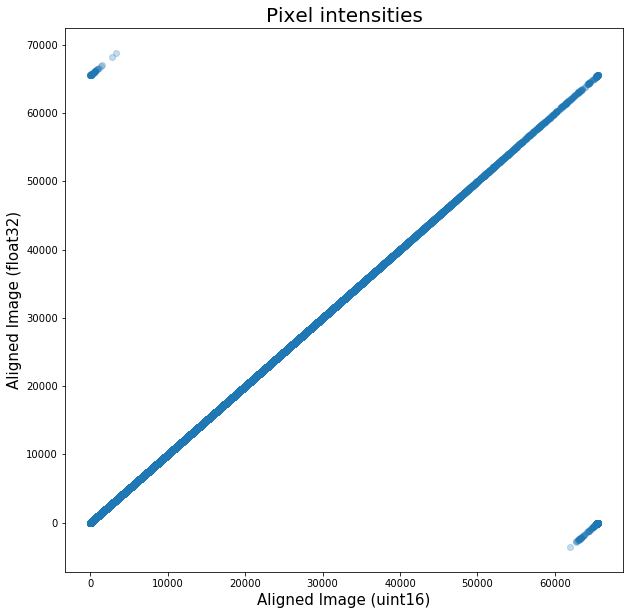

In [64]:
# Sample 1'000'000 pixel indices
idx = random.sample(range(0, fixed_img_dapi.size), 1_000_000)

plt.scatter(test_img_uint.ravel()[idx], test_img_float.ravel()[idx], alpha=0.25)
plt.xlabel("Aligned Image (uint16)", fontsize=15)
plt.ylabel("Aligned Image (float32)", fontsize=15)
plt.title("Pixel intensities", fontsize=20)
plt.show()

The reason some values go beyond the actual limits of uint16 is most likely because i) the images have been rescaled so some pixels are clipped and ii) elastix was using a bspline interpolator. [This video](https://www.youtube.com/watch?v=poY_nGzEEWM) gives a very nice explanation for why bicubic interpolation (which is similar to bspline interpolation) can lead to values higher or lower than the maximum or minimum value of the image you feed into the alignment algorithm.  
In order to test this, we can run the translation with a linear interpolator instead:

In [164]:
start = datetime.now()

elstx_aligned_lin = sitk.ElastixImageFilter()
elstx_aligned_lin.SetFixedImage(sitk.GetImageFromArray(fixed_img_dapi))
elstx_aligned_lin.SetMovingImage(sitk.GetImageFromArray(moving_img_dapi))
param_map_lin = sitk.ReadParameterFile('Elastix/param_maps/translation.txt')
param_map_lin["Interpolator"] = ["LinearInterpolator"]
param_map_lin["ResampleInterpolator"] = ["FinalLinearInterpolator"]
elstx_aligned_lin.SetParameterMap(param_map_lin)
img_aligned_lin = elstx_aligned_lin.Execute()

print(datetime.now()-start)

0:02:29.603141


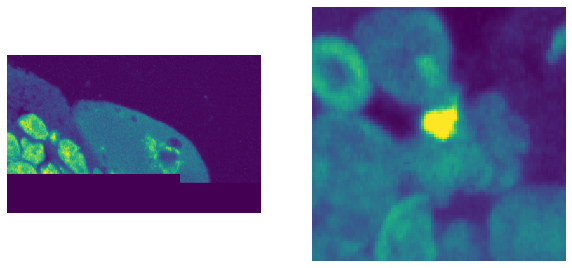

dtype: float32


In [178]:
array_aligned_lin = sitk.GetArrayFromImage(img_aligned_lin)

fig, ax = plt.subplots(1,2)
ax[0].imshow(array_aligned_lin[7500:7750, 3500:3900])
ax[0].axis("off")
ax[1].imshow(array_aligned_lin[5000:5100, 4175:4275])
ax[1].axis("off")

plt.show()

print("dtype:", array_aligned_lin.dtype)

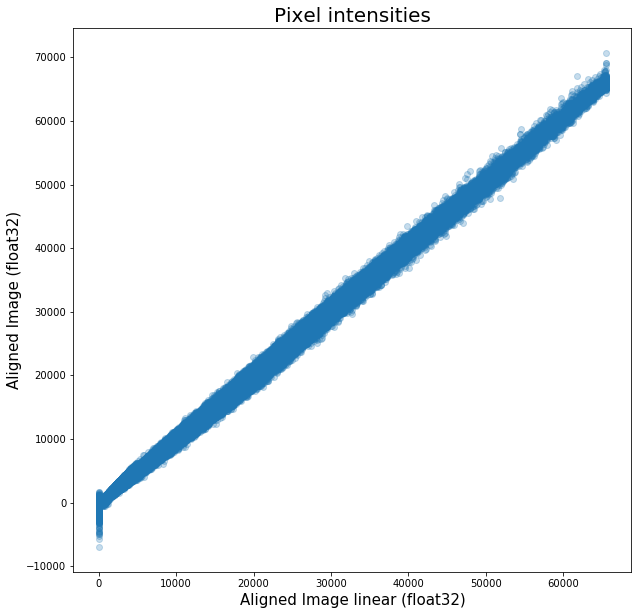

Minimum and maximum intensities of linearly interpolated image:
[0.0, 65535.0]


In [179]:
plt.scatter(array_aligned_lin.ravel()[idx], test_img_float.ravel()[idx], alpha=0.25)
plt.xlabel("Aligned Image linear (float32)", fontsize=15)
plt.ylabel("Aligned Image (float32)", fontsize=15)
plt.title("Pixel intensities", fontsize=20)
plt.show()

print("Minimum and maximum intensities of linearly interpolated image:\n[{}, {}]".format(
    np.min(array_aligned_lin), np.max(array_aligned_lin)))

It looks like the weird artefacts are no longer visible in the zoomed in areas, and values don't go below 0 or above 65535 which confirms that these extreme values were caused by the interpolation method.  
Since generally speaking a nonlinear interpolator yields better results though (see both elastix manual and the video I posted above), I will try to run elastix without scaling the intensities and with a bspline interpolator.

In [7]:
# Extract DAPI channels again
fixed_img_dapi = fixed_img_all[..., 2]
moving_img_dapi = moving_img_all[..., 2]

In [9]:
start = datetime.now()

elstx_aligned_unscaled = sitk.ElastixImageFilter()
elstx_aligned_unscaled.SetFixedImage(sitk.GetImageFromArray(fixed_img_dapi))
elstx_aligned_unscaled.SetMovingImage(sitk.GetImageFromArray(moving_img_dapi))
elstx_aligned_unscaled.SetParameterMap(sitk.ReadParameterFile('Elastix/param_maps/translation.txt'))
#elstx_aligned_unscaled.SetOutputDirectory()
img_aligned_unscaled = elstx_aligned_unscaled.Execute()

print(datetime.now()-start)

0:02:23.157580


In [29]:
# Turn aligned image to numpy array (still float32 dtype)
unscaled_array_float = sitk.GetArrayFromImage(img_aligned_unscaled)

# Cast aligned image to uint16 for comparison
img_aligned_unscaled_uint = sitk.Cast(img_aligned_unscaled, sitk.sitkUInt16)
unscaled_array_uint = sitk.GetArrayFromImage(img_aligned_unscaled_uint)

In [30]:
print("Minimum and maximum intensities of unscaled unaligned image:\n[{}, {}]".format(
    np.min(moving_img_dapi), np.max(moving_img_dapi)))
print("Minimum and maximum intensities of unscaled aligned image (float32):\n[{}, {}]".format(
    np.min(unscaled_array_float), np.max(unscaled_array_float)))
print("Minimum and maximum intensities of unscaled aligned image (converted to uint16):\n[{}, {}]".format(
    np.min(unscaled_array_uint), np.max(unscaled_array_uint)))

Minimum and maximum intensities of unscaled unaligned image:
[0, 2207]
Minimum and maximum intensities of unscaled aligned image (float32):
[-51.173336029052734, 2196.1142578125]
Minimum and maximum intensities of unscaled aligned image (converted to uint16):
[0, 65535]


Using the unscaled images achieved that no intensities go above 2^16 because no value is even close to that in the original image. Since the lowest value initially was 0, however, the aligned image has intensities that go into the negative. The image below shows the effect of this, with all values of the converted image being similar to the float32 values but for a few pixels (i.e. the ones that are below 0 in the float32 image) the intensities suddenly shoot up to 2^16 as was described before.

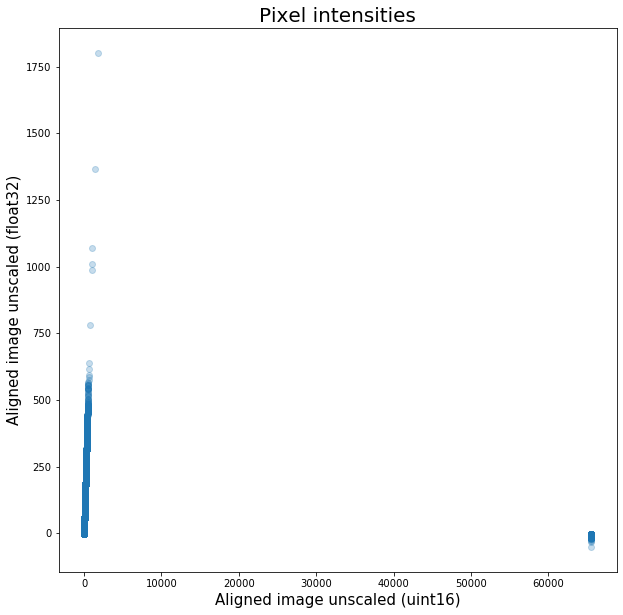

In [22]:
plt.scatter(unscaled_array_uint.ravel()[idx], unscaled_array_float.ravel()[idx], alpha=0.25)
plt.xlabel("Aligned image unscaled (uint16)", fontsize=15)
plt.ylabel("Aligned image unscaled (float32)", fontsize=15)
plt.title("Pixel intensities", fontsize=20)
plt.show()

A way around this could be to  
- convert the float32 image to a numpy array
- set all values <0 = 0
- just for good measure, set all values >65535 = 65535
- convert to uint16  

Since we already did the first step and saved it as `unscaled_array_float` we can skip that

In [31]:
# Cap values at zero
unscaled_array_float[unscaled_array_float < 0] = 0
# Cap values at 65535
unscaled_array_float[unscaled_array_float > 65535] = 65535
# Convert to uint16
unscaled_array_uint = unscaled_array_float.astype(np.uint16)

print("Minimum and maximum intensities of unscaled aligned image (float32):\n[{}, {}]".format(
    np.min(unscaled_array_float), np.max(unscaled_array_float)))
print("Minimum and maximum intensities of unscaled aligned image (converted to uint16):\n[{}, {}]".format(
    np.min(unscaled_array_uint), np.max(unscaled_array_uint)))

Minimum and maximum intensities of unscaled aligned image (float32):
[0.0, 2196.1142578125]
Minimum and maximum intensities of unscaled aligned image (converted to uint16):
[0, 2196]


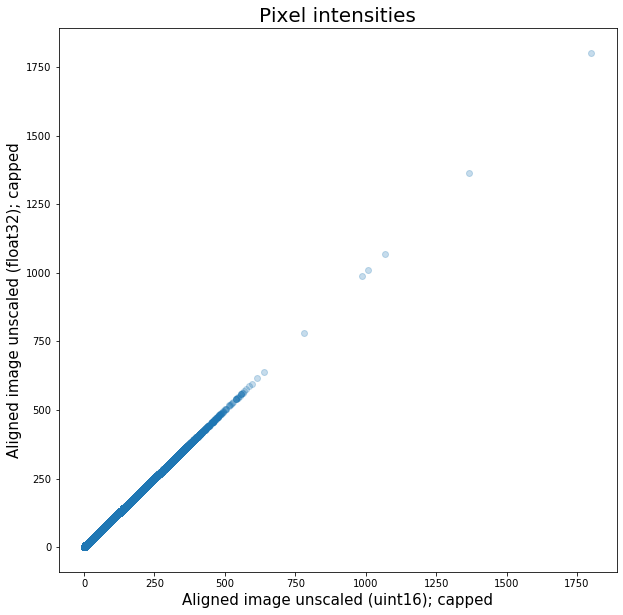

In [39]:
plt.scatter(unscaled_array_uint.ravel()[idx], unscaled_array_float.ravel()[idx], alpha=0.25)
plt.xlabel("Aligned image unscaled (uint16); capped", fontsize=15)
plt.ylabel("Aligned image unscaled (float32); capped", fontsize=15)
plt.title("Pixel intensities", fontsize=20)
plt.show()